In [1]:

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
import rioxarray
import pandas as pd
import seaborn as sns

# Climat Dataset

In [ ]:
file_path = "../data/landcover_total_clean.gpkg"

df_final_clean = gpd.read_file(file_path)

print(f"Jeu de données rechargé dans la variable 'df_final_clean' avec {df_final_clean.shape[0]} lignes.")

Jeu de données rechargé dans la variable 'df_final_clean' avec 438513 lignes.


### Pour clipper

In [ ]:

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = ["precip", "tmin", "tmax"]

# Utiliser le GeoDataFrame chargé précédemment
landcover = df_final_clean
#  Boucle sur chaque variable 
for var in variables:
    
    input_dir = os.path.join(base_dir, var)
    output_dir = os.path.join(base_dir, f"{var}_alg_tun3")
    os.makedirs(output_dir, exist_ok=True)
    
    # Lister les fichiers .tif (12 mois * 5 années = 60 fichiers)
    tif_files = sorted(glob(os.path.join(input_dir, "*.tif")))
    for idx, tif_file in enumerate(tif_files, 1):
        try:
            # Charger le raster climatique
            ds = rioxarray.open_rasterio(tif_file)
            
            # Reprojeter le shapefile si besoin
            if landcover.crs != ds.rio.crs:
                landcover = landcover.to_crs(ds.rio.crs)
            
            # Découper avec le shapefile fusionné
            ds_crop = ds.rio.clip(landcover.geometry, landcover.crs)
            
            # Sauvegarder le résultat
            output_path = os.path.join(output_dir, os.path.basename(tif_file))
            ds_crop.rio.to_raster(output_path)
            
        except Exception as e:
            print(f"    [{idx}/{len(tif_files)}] Erreur sur {os.path.basename(tif_file)} : {e}")
    

# Exploration univariée  Climat Dataset


Précipitations - ANALYSE DE TOUS LES FICHIERS (12 fichiers)
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°

    Lecture de 12 fichiers...
      Progression: 10/12 fichiers traités

    STATISTIQUES GLOBALES (tous les fichiers combinés)
   ────────────────────────────────────────────────────────────
   Nombre total de fichiers : 12
   Nombre total de pixels   : 395,124
   Valeur min               : 0.00 mm
   Valeur max               : 266.15 mm
   Moyenne globale          : 5.30 mm
   Écart-type global        : 11.14 mm
   Médiane                  : 1.73 mm
   Percentile 25%           : 0.80 mm
   Percentile 75%           : 4.47 mm
      Progression: 10/12 fichiers traités

    STATISTIQUES GLOBALES (tous les fichiers combinés)
   ────────────────────────────────────────────────────────────
   Nombre total de fichiers : 12
   Nombre total de pixels   : 395,124
   Valeur min               : 0.00 mm
   Valeur max               : 266.15 

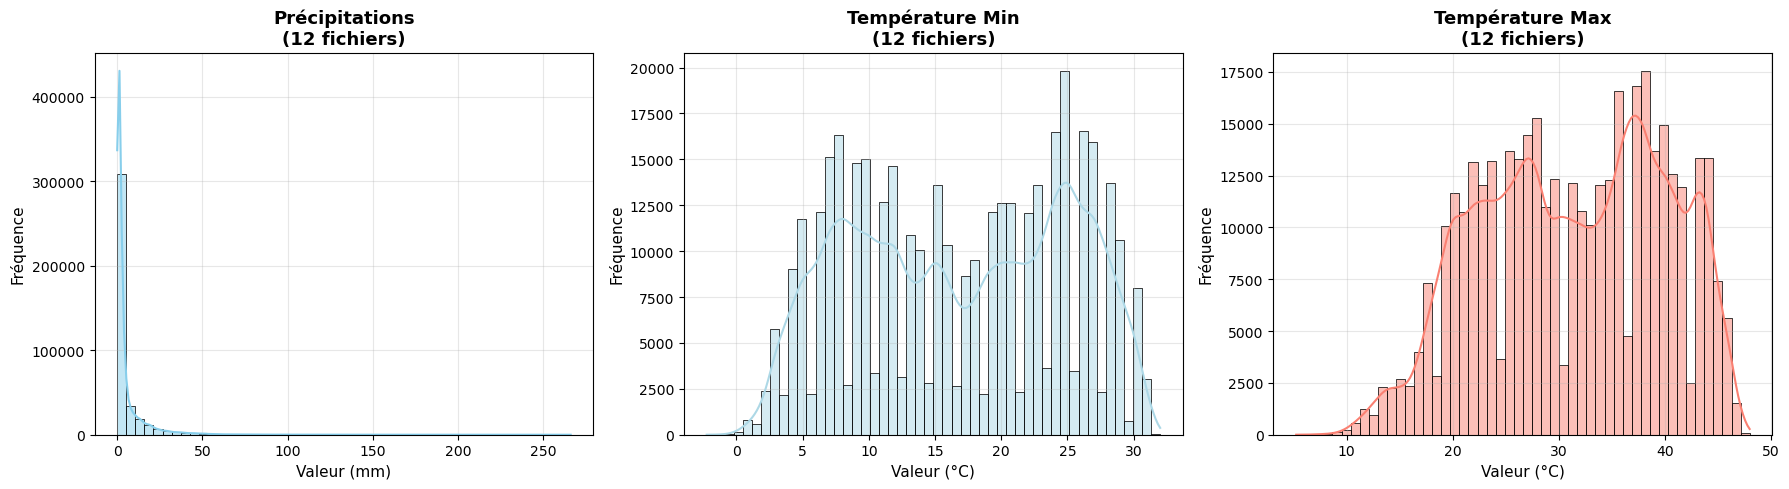

In [56]:
import numpy as np

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat\nv"
variables = {
    "precip_alg_tun3": {"nom": "Précipitations", "unite": "mm", "couleur": "skyblue"},
    "tmin_alg_tun3": {"nom": "Température Min", "unite": "°C", "couleur": "lightblue"},
    "tmax_alg_tun3": {"nom": "Température Max", "unite": "°C", "couleur": "salmon"}
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (var_dir, var_info) in enumerate(variables.items()):
    raster_files = glob(os.path.join(base_dir, var_dir, "*.tif"))
    
    if len(raster_files) > 0:
        print(f"\n{'='*70}")
        print(f"{var_info['nom']} - ANALYSE DE TOUS LES FICHIERS ({len(raster_files)} fichiers)")
        print('='*70)
        
        # Liste pour stocker toutes les données de tous les fichiers
        all_data = []
        
        # Lire le premier fichier pour obtenir les métadonnées
        with rasterio.open(raster_files[0]) as raster:
            print(f"   Dimensions      : {raster.width} x {raster.height} pixels")
            print(f"   CRS             : {raster.crs}")
            print(f"   Résolution      : {raster.res[0]:.4f}°")
            nodata_value = raster.nodata
        
        # Lire TOUS les fichiers et combiner les données
        print(f"\n    Lecture de {len(raster_files)} fichiers...")
        for i, raster_path in enumerate(raster_files, 1):
            if i % 10 == 0:
                print(f"      Progression: {i}/{len(raster_files)} fichiers traités")
            
            with rasterio.open(raster_path) as raster:
                data = raster.read(1).astype(float)
                
                # Nettoyer les données
                if nodata_value is not None:
                    data = data[data != nodata_value]
                
                data = data[~np.isnan(data)]
                data = data[~np.isinf(data)]
                
                # Ajouter à la liste globale
                all_data.extend(data.flatten())
        
        # Convertir en array numpy
        data_flat = np.array(all_data)
        
        if len(data_flat) > 0:
            print(f"\n    STATISTIQUES GLOBALES (tous les fichiers combinés)")
            print(f"   {'─'*60}")
            print(f"   Nombre total de fichiers : {len(raster_files)}")
            print(f"   Nombre total de pixels   : {len(data_flat):,}")
            print(f"   Valeur min               : {data_flat.min():.2f} {var_info['unite']}")
            print(f"   Valeur max               : {data_flat.max():.2f} {var_info['unite']}")
            print(f"   Moyenne globale          : {data_flat.mean():.2f} {var_info['unite']}")
            print(f"   Écart-type global        : {data_flat.std():.2f} {var_info['unite']}")
            print(f"   Médiane                  : {np.median(data_flat):.2f} {var_info['unite']}")
            print(f"   Percentile 25%           : {np.percentile(data_flat, 25):.2f} {var_info['unite']}")
            print(f"   Percentile 75%           : {np.percentile(data_flat, 75):.2f} {var_info['unite']}")
        else:
            print(f"    Aucune donnée valide trouvée!")
            data_flat = np.array([0])
        
        # Histogramme
        if len(data_flat) > 0:
            sns.histplot(data_flat, bins=50, kde=True, 
                        color=var_info['couleur'], ax=axes[idx])
            axes[idx].set_title(f"{var_info['nom']}\n({len(raster_files)} fichiers)", 
                              fontsize=13, fontweight='bold')
            axes[idx].set_xlabel(f"Valeur ({var_info['unite']})", fontsize=11)
            axes[idx].set_ylabel("Fréquence", fontsize=11)
            axes[idx].grid(True, alpha=0.3)
        else:
            axes[idx].text(0.5, 0.5, "Pas de données valides", 
                          ha='center', va='center', fontsize=12)
            axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')
    else:
        print(f"\n Aucun fichier trouvé dans {var_dir}/")
        axes[idx].text(0.5, 0.5, f"Pas de données\n{var_info['nom']}", 
                      ha='center', va='center', fontsize=12)
        axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### Analyse bivariee 

In [57]:
import xarray as xr
import pandas as pd
import os
from glob import glob
import numpy as np

# Répertoire de base contenant les dossiers de variables découpées
base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat\nv"
variables = ["precip", "tmin", "tmax"]

# Dictionnaire pour stocker les DataArrays
data_arrays = {}

for var in variables:
    # Chemin vers les TIFs découpés
    input_dir = os.path.join(base_dir, f"{var}_alg_tun3")
    tif_files = sorted(glob(os.path.join(input_dir, "*.tif")))
    
    # Créer une liste pour stocker les DataArrays de chaque mois
    monthly_das = []
    
    # Extraire les dates RÉELLES depuis les noms de fichiers
    # Format attendu : wc2.1_cruts4.09_5m_prec_2024-01.tif
    dates = []
    for tif_file in tif_files:
        filename = os.path.basename(tif_file)  # Ex: wc2.1_cruts4.09_5m_prec_2024-01.tif
        # Extraire la partie YYYY-MM (dernière partie avant .tif)
        date_str = filename.split('_')[-1].replace('.tif', '')  # Ex: 2024-01
        try:
            # Convertir en datetime (ajouter -01 pour le premier jour du mois)
            date = pd.to_datetime(date_str + '-01')
            dates.append(date)
        except Exception as e:
            print(f"  Impossible d'extraire la date de {filename}: {e}")
    
    dates = pd.DatetimeIndex(dates)
    print(f" {var}: {len(dates)} fichiers trouvés - Période: {dates.min().strftime('%Y-%m')} à {dates.max().strftime('%Y-%m')}")
    
    
    # Lire tous les fichiers TIF et créer un DataArray temporel
    try:
        # Ouvrir plusieurs fichiers en même temps et créer une nouvelle dimension 'time'
        da_var = xr.open_mfdataset(tif_files, combine='nested', concat_dim='time', engine='rasterio')
        
        # Le résultat est un Dataset, extraire le DataArray
        # Je prends le premier DataArray dans le Dataset
        key_da = list(da_var.keys())[0]
        da_var = da_var[key_da]
        
        # Assigner la dimension temporelle
        da_var['time'] = dates
        
        data_arrays[var] = da_var
        print(f"DataArray pour {var} créé avec la dimension temporelle de {len(dates)} étapes.")
    except Exception as e:
        print(f"Erreur lors de la lecture des fichiers TIF pour {var} : {e}")

 precip: 12 fichiers trouvés - Période: 2024-01 à 2024-12
DataArray pour precip créé avec la dimension temporelle de 12 étapes.
 tmin: 12 fichiers trouvés - Période: 2024-01 à 2024-12
DataArray pour tmin créé avec la dimension temporelle de 12 étapes.
DataArray pour precip créé avec la dimension temporelle de 12 étapes.
 tmin: 12 fichiers trouvés - Période: 2024-01 à 2024-12
DataArray pour tmin créé avec la dimension temporelle de 12 étapes.
 tmax: 12 fichiers trouvés - Période: 2024-01 à 2024-12
DataArray pour tmax créé avec la dimension temporelle de 12 étapes.
 tmax: 12 fichiers trouvés - Période: 2024-01 à 2024-12
DataArray pour tmax créé avec la dimension temporelle de 12 étapes.


In [58]:
# S'assurer que tous les DataArrays sont dans le dictionnaire
if len(data_arrays) < 3:
    print("Impossible de continuer : il manque des DataArrays.")
else:
    # Créer un Dataset
    ds_climat = xr.Dataset(data_arrays)

    # Convertir en DataFrame pour le calcul de corrélation
    # Empiler (stack) les dimensions spatiales (y et x) en une seule dimension 'pixel'
    # et transposer (T) pour avoir les variables en colonnes et le temps/pixel en lignes
    df_climat = ds_climat.to_dataframe()
    df_climat = df_climat.unstack(level=['y', 'x']) # Remettre les pixels en colonnes

    # Transposer pour avoir les variables (precip, tmin, tmax) en colonnes
    # Les indices (time, y, x) deviennent des indices du DataFrame (multi-index)
    df_climat = ds_climat.to_dataframe().dropna()

    # Le DataFrame pour la corrélation doit avoir les variables en colonnes
    # df_climat contient 'precip', 'tmin', 'tmax' comme colonnes (multi-index des variables)
    
    # L'index est (time, y, x). On veut la corrélation entre les colonnes 'precip', 'tmin', 'tmax'
    
    # Nettoyer le DataFrame: Supprimer les colonnes 'band' 
    if 'band' in df_climat.columns:
        df_climat = df_climat.drop(columns='band')
    if 'spatial_ref' in df_climat.columns:
        df_climat = df_climat.drop(columns='spatial_ref')

    correlation_matrix = df_climat.corr()

In [59]:
print("\n Matrice de Corrélation ")
print(correlation_matrix)


 Matrice de Corrélation 
          precip      tmin      tmax
precip  1.000000 -0.215508 -0.335810
tmin   -0.215508  1.000000  0.974793
tmax   -0.335810  0.974793  1.000000


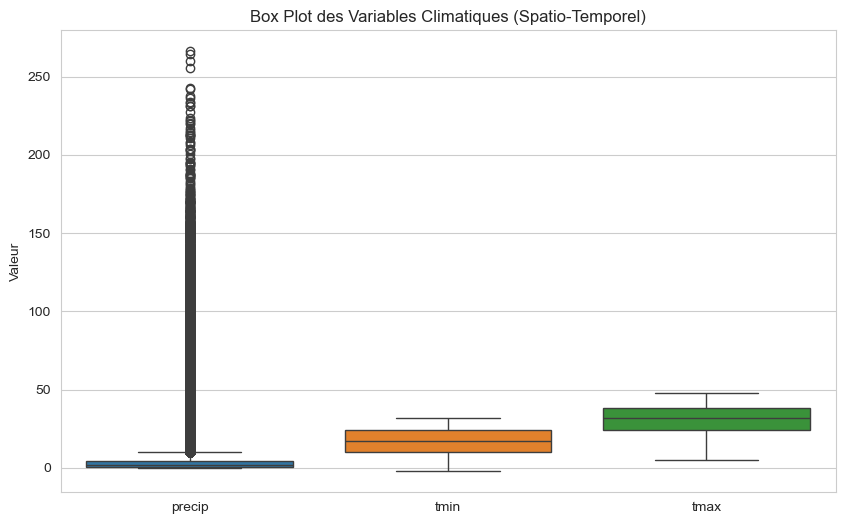

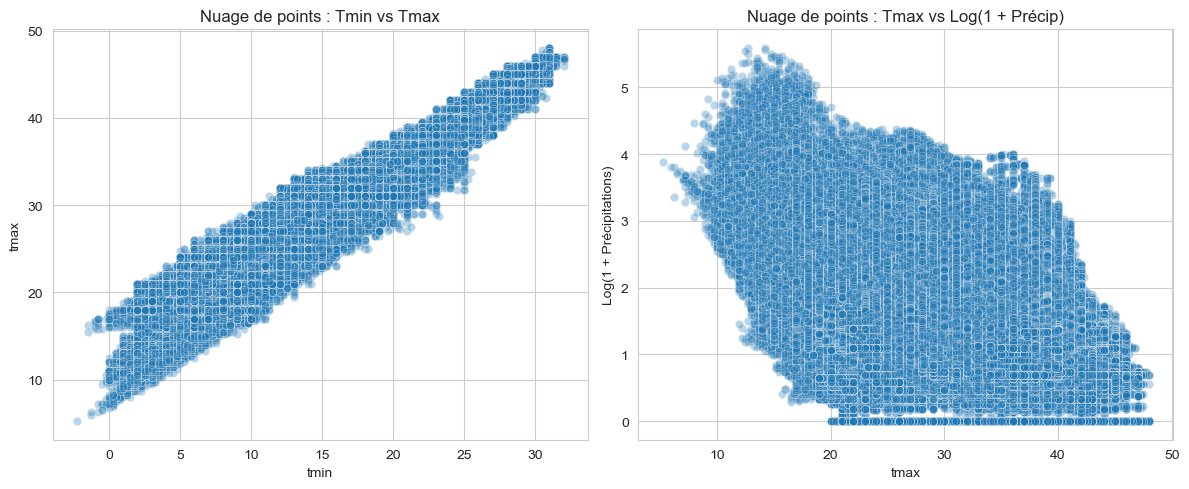

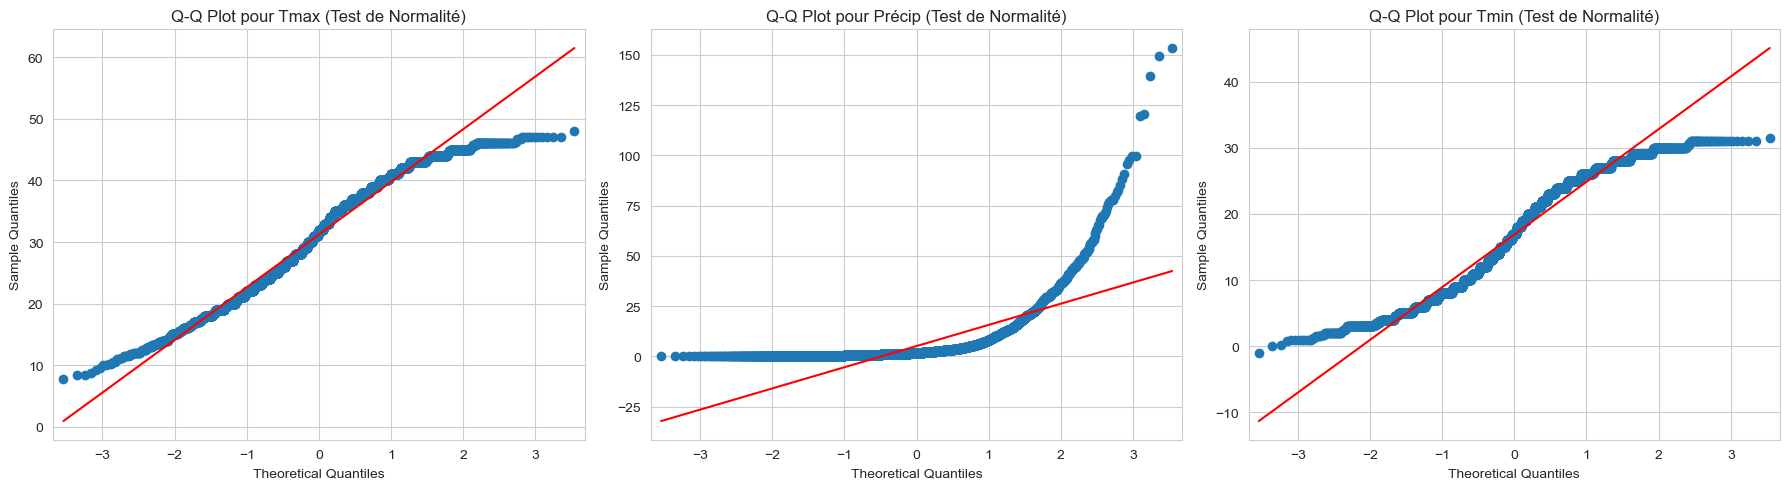

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # Nécessaire pour les Q-Q Plots


# Configuration de base
sns.set_style("whitegrid")

# --- 1. Box Plots (Univarié) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_climat[['precip', 'tmin', 'tmax']])
plt.title('Box Plot des Variables Climatiques (Spatio-Temporel)')
plt.ylabel('Valeur')
plt.show()

# --- 2. Scatter Plots (Bivarié) ---
plt.figure(figsize=(12, 5))

# Scatter Plot Tmin vs Tmax
plt.subplot(1, 2, 1)
sns.scatterplot(x='tmin', y='tmax', data=df_climat, alpha=0.3)
plt.title('Nuage de points : Tmin vs Tmax')

# Scatter Plot Précip vs Tmax (utiliser une échelle log pour la précipitation)
# Ajouter une petite constante pour éviter log(0)
epsilon = 0.01 
plt.subplot(1, 2, 2)
sns.scatterplot(x='tmax', y=np.log1p(df_climat['precip']), data=df_climat, alpha=0.3)
plt.title('Nuage de points : Tmax vs Log(1 + Précip)')
plt.ylabel('Log(1 + Précipitations)')

plt.tight_layout()
plt.show()


# --- 3. Q-Q Plots = ---

plt.figure(figsize=(18, 5))

# Q-Q Plot pour Tmax
plt.subplot(1, 3, 1)
sm.qqplot(df_climat['tmax'].sample(5000), line='s', ax=plt.gca()) 
plt.title('Q-Q Plot pour Tmax (Test de Normalité)')

# Q-Q Plot pour Précip
plt.subplot(1, 3, 2)
sm.qqplot(df_climat['precip'].sample(5000), line='s', ax=plt.gca())
plt.title('Q-Q Plot pour Précip (Test de Normalité)')

# Q-Q Plot pour Tmin
plt.subplot(1, 3, 3)
sm.qqplot(df_climat['tmin'].sample(5000), line='s', ax=plt.gca())
plt.title('Q-Q Plot pour Tmin (Test de Normalité)')

plt.tight_layout()
plt.show()

## Pretraitement 

### Outliers in precipitation

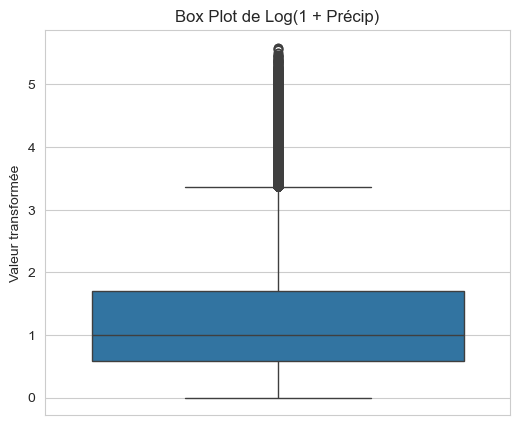

In [61]:
# Code pour la transformation et la visualisation
df_climat['log_precip'] = np.log1p(df_climat['precip'])

# Nouveau Box Plot avec les données transformées
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_climat.reset_index(), y='log_precip')
plt.title('Box Plot de Log(1 + Précip)')
plt.ylabel('Valeur transformée')
plt.show()

### Forte Correlation entre tmin et tmax

Eleminer tmin , le remplacer par l'amplitude (tmax-tmin)

Anaylyse Univariee  de l'amplitude 


 Statistiques de l'amplitude thermique :
   Moyenne    : 14.52 °C
   Min        : 5.50 °C
   Max        : 20.25 °C
   Écart-type : 1.93 °C
   Médiane    : 15.00 °C


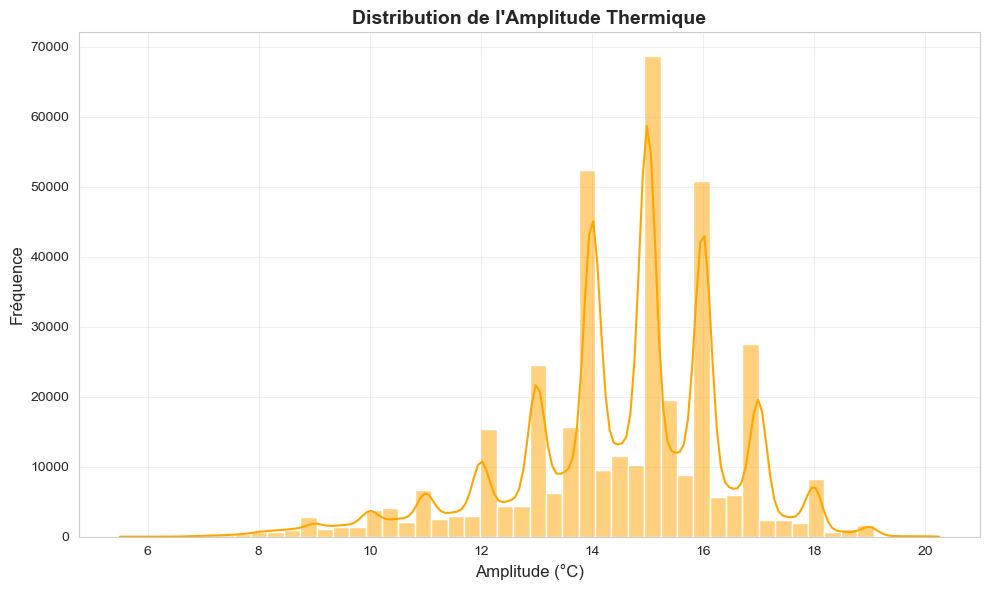

In [62]:
# Créer la variable amplitude thermique
df_climat['amplitude_thermique'] = df_climat['tmax'] - df_climat['tmin']

# Statistiques descriptives
print(f"\n Statistiques de l'amplitude thermique :")
print(f"   Moyenne    : {df_climat['amplitude_thermique'].mean():.2f} °C")
print(f"   Min        : {df_climat['amplitude_thermique'].min():.2f} °C")
print(f"   Max        : {df_climat['amplitude_thermique'].max():.2f} °C")
print(f"   Écart-type : {df_climat['amplitude_thermique'].std():.2f} °C")
print(f"   Médiane    : {df_climat['amplitude_thermique'].median():.2f} °C")


plt.figure(figsize=(10, 6))
sns.histplot(df_climat['amplitude_thermique'], bins=50, kde=True, 
             color='orange')
plt.title("Distribution de l'Amplitude Thermique", fontweight='bold', fontsize=14)
plt.xlabel("Amplitude (°C)", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Suppresion des doublons et verification des valeurs manquantes 

### Créer le dataset avec les 3 variables optimales 

In [63]:
df_climat_final = df_climat[['log_precip', 'tmax', 'amplitude_thermique']].copy()

print(f"\n Variables APRÈS sélection : {list(df_climat_final.columns)}")
print(f"   Nombre de lignes : {len(df_climat_final):,}")



 Variables APRÈS sélection : ['log_precip', 'tmax', 'amplitude_thermique']
   Nombre de lignes : 395,124


### Vérification des valeurs manquantes

In [64]:
missing_values = df_climat_final.isnull().sum()
missing_percent = (missing_values / len(df_climat_final)) * 100

missing_df = pd.DataFrame({
    'Variable': missing_values.index,
    'Valeurs manquantes': missing_values.values,
    'Pourcentage (%)': missing_percent.values
})

print(missing_df.to_string(index=False))

total_missing = df_climat_final.isnull().sum().sum()
if total_missing > 0:
    print(f"\n  Total de valeurs manquantes : {total_missing:,}")
    df_climat_final = df_climat_final.dropna()
    print(f" Lignes avec NaN supprimées")
else:
    print(f"\n Aucune valeur manquante détectée")

           Variable  Valeurs manquantes  Pourcentage (%)
         log_precip                   0              0.0
               tmax                   0              0.0
amplitude_thermique                   0              0.0

 Aucune valeur manquante détectée


### Suppression des doublons

In [65]:
duplicates_before = df_climat_final.duplicated().sum()
print(f"Doublons détectés : {duplicates_before:,} ({duplicates_before/len(df_climat_final)*100:.2f}%)")

if duplicates_before > 0:
    lignes_avant = len(df_climat_final)
    df_climat_final = df_climat_final.drop_duplicates()
    print(f" {lignes_avant - len(df_climat_final):,} doublons supprimés")
else:
    print(" Aucun doublon détecté")

print(f"\n Nombre de lignes après nettoyage : {len(df_climat_final):,}")


Doublons détectés : 246,832 (62.47%)
 246,832 doublons supprimés

 Nombre de lignes après nettoyage : 148,292
 246,832 doublons supprimés

 Nombre de lignes après nettoyage : 148,292


### Analyse Finale

log_precip:
   Bornes IQR : [-1.39, 5.21]
   Outliers   : 56 (0.04%)
tmax:
   Bornes IQR : [0.38, 55.38]
   Outliers   : 0 (0.00%)
amplitude_thermique:
   Bornes IQR : [7.50, 19.50]
   Outliers   : 396 (0.27%)

 Visualisation des outliers (Box Plots)


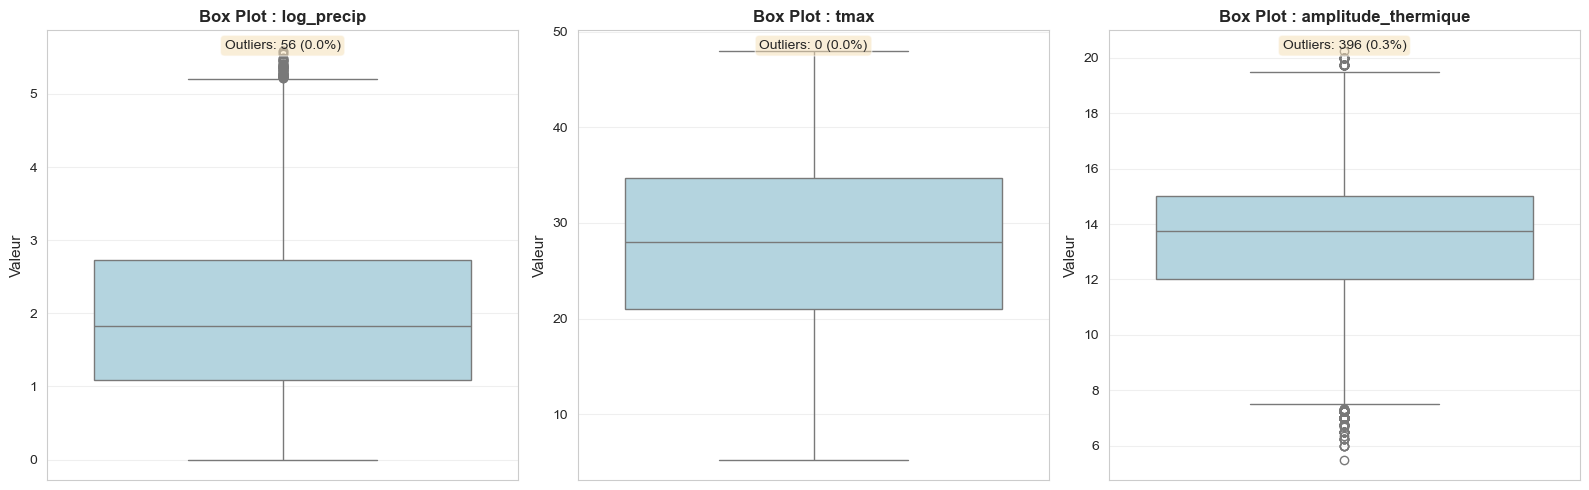

In [66]:

outliers_summary = {}
for col in df_climat_final.columns:
    Q1 = df_climat_final[col].quantile(0.25)
    Q3 = df_climat_final[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_climat_final[(df_climat_final[col] < lower_bound) | 
                               (df_climat_final[col] > upper_bound)]
    n_outliers = len(outliers)
    outliers_summary[col] = {
        'n_outliers': n_outliers,
        'percent': (n_outliers / len(df_climat_final)) * 100
    }
    
    print(f"{col}:")
    print(f"   Bornes IQR : [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"   Outliers   : {n_outliers:,} ({outliers_summary[col]['percent']:.2f}%)")

# Visualisation des outliers avec box plots
print("\n Visualisation des outliers (Box Plots)")

df_for_plot = df_climat_final.reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, col in enumerate(df_climat_final.columns):
    sns.boxplot(data=df_for_plot, y=col, ax=axes[idx], color='lightblue')
    axes[idx].set_title(f'Box Plot : {col}', fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('Valeur', fontsize=11)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Ajouter statistiques
    n_outliers = outliers_summary[col]['n_outliers']
    axes[idx].text(0.5, 0.98, f'Outliers: {n_outliers:,} ({outliers_summary[col]["percent"]:.1f}%)',
                   transform=axes[idx].transAxes,
                   ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=10)

plt.tight_layout()
plt.show()



 STATISTIQUES FINALES :
──────────────────────────────────────────────────────────────────────
          log_precip           tmax  amplitude_thermique
count  148292.000000  148292.000000        148292.000000
mean        1.937326      27.828146            13.428387
std         1.034870       8.222783             2.213237
min         0.000000       5.250000             5.500000
25%         1.081805      21.000000            12.000000
50%         1.824549      28.000000            13.750000
75%         2.732743      34.750000            15.000000
max         5.587810      48.000000            20.250000

 MATRICE DE CORRÉLATION FINALE :
──────────────────────────────────────────────────────────────────────
                     log_precip      tmax  amplitude_thermique
log_precip             1.000000 -0.379220            -0.685355
tmax                  -0.379220  1.000000             0.467594
amplitude_thermique   -0.685355  0.467594             1.000000


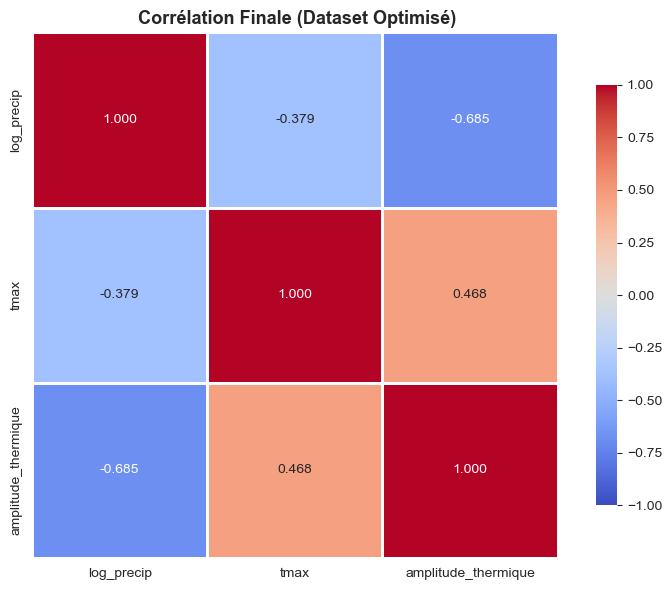

In [67]:
# Statistiques finales
print("\n STATISTIQUES FINALES :")
print("─" * 70)
print(df_climat_final.describe())

# Matrice de corrélation finale
print("\n MATRICE DE CORRÉLATION FINALE :")
print("─" * 70)
correlation_finale = df_climat_final.corr()
print(correlation_finale)

# Visualisation finale
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_finale, annot=True, cmap='coolwarm', 
            center=0, square=True, linewidths=2, 
            cbar_kws={"shrink": 0.8}, fmt='.3f',
            vmin=-1, vmax=1)
plt.title(" Corrélation Finale (Dataset Optimisé)", fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()


In [68]:
#  Réinitialiser l'index complètement
df_climat_final_clean = df_climat_final.reset_index()

# Renommer x et y en longitude et latitude
if 'x' in df_climat_final_clean.columns:
    df_climat_final_clean = df_climat_final_clean.rename(columns={'x': 'longitude', 'y': 'latitude'})
    print(" Colonnes renommées : x → longitude, y → latitude")

# Supprimer la colonne 'band' si elle existe maintenant
if 'band' in df_climat_final_clean.columns:
    df_climat_final_clean = df_climat_final_clean.drop(columns='band')
    print(" Colonne 'band' supprimée de l'index")

print("\n Colonnes finales :", df_climat_final_clean.columns.tolist())
print(f" Dimensions : {df_climat_final_clean.shape}")

# Sauvegarder la version propre
output_path_csv = "../data/climat_clean.csv"
df_climat_final_clean.to_csv(output_path_csv, index=False)
print(f"\n Dataset sauvegardé SANS 'band' : {output_path_csv}")

 Colonnes renommées : x → longitude, y → latitude
 Colonne 'band' supprimée de l'index

 Colonnes finales : ['longitude', 'latitude', 'time', 'log_precip', 'tmax', 'amplitude_thermique']
 Dimensions : (148292, 6)

 Dataset sauvegardé SANS 'band' : ../data/climat_clean.csv

 Dataset sauvegardé SANS 'band' : ../data/climat_clean.csv
